홀수 학번이므로 amazon_uk_shoes_products_dataset_2021_12.csv 데이터를 분석하겠습니다.

데이터를 로드하고, 데이터프레임의 기본 정보를 확인합니다.

In [31]:
import pandas as pd

# 데이터 불러오기 (출처: amazon_uk_shoes_products_dataset_2021_12.csv 파일)
df = pd.read_csv('amazon_uk_shoes_products_dataset_2021_12.csv')

# 데이터프레임의 기본 정보 확인
print(df.head()) # 상위 5개의 행 출력
print(df.info()) # 데이터프레임의 요약 정보 출력
print(df.describe()) # 데이터프레임의 기술 통계 정보 출력
print(df.columns) # 컬럼명 출력

                                      url  \
0  https://www.amazon.co.uk/dp/B07SBX32T5   
1  https://www.amazon.co.uk/dp/B07SBX32T5   
2  https://www.amazon.co.uk/dp/B07SBX32T5   
3  https://www.amazon.co.uk/dp/B07SBX32T5   
4  https://www.amazon.co.uk/dp/B08SW434MG   

                                        product_name     reviewer_name  \
0  Klasified Women's Transparent Clear Sneaker Sh...  Jocelyn McSayles   
1  Klasified Women's Transparent Clear Sneaker Sh...      Kenia Rivera   
2  Klasified Women's Transparent Clear Sneaker Sh...       Chris Souza   
3  Klasified Women's Transparent Clear Sneaker Sh...   Amazon Customer   
4  GUESS Women's Bradly Gymnastics Shoe, White, 7 UK         Graziella   

         review_title                                        review_text  \
0             Love em  Love these. Was looking for converses and thes...   
1  The plastic ripped  The shoes are very cute, but after the 2nd day...   
2        Good quality                                   

결측값을 확인합니다.

In [32]:
# 결측값 확인
print(df.isnull().sum())

url                     0
product_name            0
reviewer_name           0
review_title            1
review_text             9
review_rating           0
verified_purchase       0
review_date             0
helpful_count        4870
uniq_id                 0
scraped_at              0
dtype: int64


결측값과 중복값을 제거합니다.

In [33]:
# 'review_text' 컬럼의 결측값 제거
df = df.dropna(subset=['review_text'])

# 'review_text' 컬럼의 중복값 제거
df = df.drop_duplicates(subset=['review_text'])

# 결측값 제거 및 중복값 제거 후 다시 확인
print(df.isnull().sum())
print(df.duplicated(subset=['review_text']).sum())

url                     0
product_name            0
reviewer_name           0
review_title            1
review_text             0
review_rating           0
verified_purchase       0
review_date             0
helpful_count        4653
uniq_id                 0
scraped_at              0
dtype: int64
0


NLTK를 사용하여 텍스트 데이터를 전처리합니다. 여기에는 토큰화, 불용어 제거, 소문자 변환, 스테밍 또는 표제어 추출이 포함됩니다.

In [34]:
# nltk 모듈 설치
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# NLTK 리소스 다운로드 (출처: https://www.nltk.org/data.html)
nltk.download('punkt')
nltk.download('stopwords')

# 텍스트 전처리 함수 정의
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    # 토큰화
    tokens = word_tokenize(text)
    # 불용어 제거 및 소문자 변환
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # 스테밍
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# 전처리 적용
df['cleaned_review_text'] = df['review_text'].apply(preprocess_text)

# 전처리된 데이터 확인
print(df[['review_text', 'cleaned_review_text']].head())

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         review_text  \
0  Love these. Was looking for converses and thes...   
1  The shoes are very cute, but after the 2nd day...   
2                                       Good quality   
3                                              Great   
4  Ho scelto il modello bianco con rifinitura die...   

                                 cleaned_review_text  
0  love look convers half price never seen clear ...  
1  shoe cute day wear tongu start rip day wear pl...  
2                                       good qualiti  
3                                              great  
4  ho scelto il modello bianco con rifinitura die...  


전처리된 텍스트 데이터를 학습 및 테스트 세트로 분할하고, 리뷰 평점을 기반으로 레이블을 이진화하여 긍정(1)과 부정(0)으로 분류합니다.

In [35]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
X = df['cleaned_review_text']
y = df['review_rating'] # 감성 레이블이 담긴 컬럼으로 가정

# 레이블 이진화
y = y.apply(lambda x: 1 if x >= 3 else 0)

# 학습 및 테스트 세트로 분할 (학습: 80%, 테스트: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TF-IDF 벡터라이저와 로지스틱 회귀 모델을 사용하여 파이프라인을 구축하고 학습시킵니다. 그런 다음, 모델의 성능을 평가합니다.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# TF-IDF 벡터라이저와 로지스틱 회귀 모델 파이프라인
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8478593272171254
Precision: 0.8501577287066246
Recall: 0.9917203311867525
F1 Score: 0.9154989384288748


혼동 행렬을 시각화하고, ROC 곡선을 그려 모델의 성능을 평가합니다.

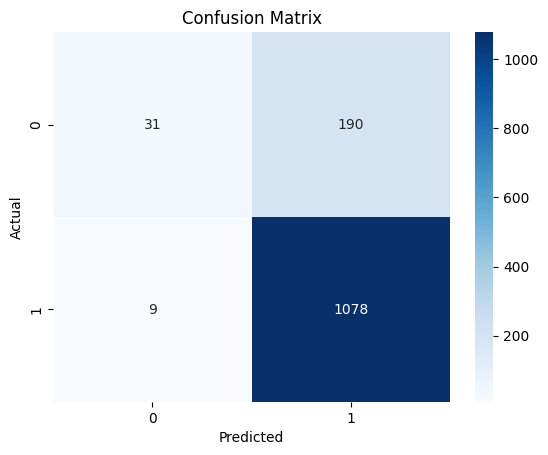

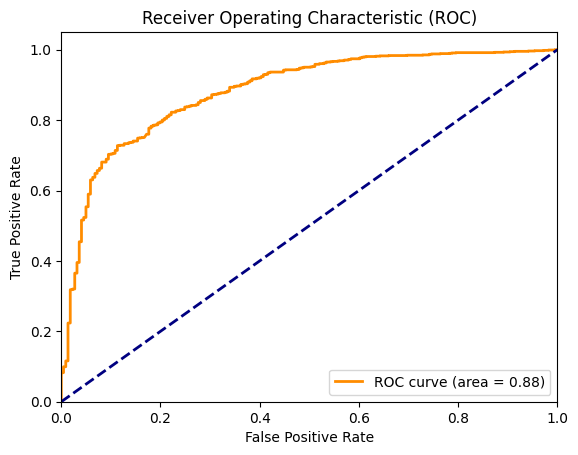

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()